## Hierarchical Wasserstein Alignment

_Aim:_ Decompose data into potential clusters and then find global alignment across two datasets by leveraging clustering structure.

_Paper describing HiWA:_ John Lee, Max Dabagia, E Dyer, C Rozell: Hierarchical Wasserstein Alignment for Multimodal Distributions, May 2019.

#### In this demo:

- Dimensionality reduction to first simplify problem
- Clustering in original and new dataset
- Alignment between clusters and then global alignment

In [1]:
# Import some necessary packages
import numpy as np
from src import utils, hiwa
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import Isomap
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Example A - Motor cortex during reaching movements (NHP)
_Data collected by:_ Matthew Perich, Lee Miller Lab (Northwestern)

#### Step 1. Apply initial dimensionality reduction

In [2]:
# Load the datasets from a .mat file
T_te, T_tr, X_te, X_tr, Y_te, Y_tr = utils.load_data('data\\mihi_demo.mat')
T_te, T_tr = T_te.squeeze(), T_tr.squeeze()

# Apply initial dimensionality reduction (n_components)
Y_te_3d = FactorAnalysis(n_components=3).fit_transform(utils.remove_const_cols(Y_te))
X_tr_3d = utils.map_X_3D(X_tr)
X_transform = np.linalg.pinv(X_tr_3d) @ X_tr

#### Step 2. Align data with HiWA

In [12]:
# Fit the model and transform the source dataset
t1 = time.time()

# This indicates to the model it should compute a low-d embedding with isomap, and that the parameter datasets will not be normalized
hwa = hiwa.HiWA(dim_red_method=Isomap(n_components=2, n_neighbors=12, eigen_solver='dense'), normalize=True)

# Fit the model, also passing in the correct rotation in Rgt since we can calculate it in this case (for computing error metrics)
# Note that we can provide the low-d mapping for either the source or target; the model will calculate whatever isn't provided
hwa.fit(Y_te_3d, T_te, X_tr_3d, T_tr, Y_transform=X_transform, Rgt=utils.LS_oracle(utils.map_X_3D(X_te), Y_te_3d))

# Transform the dataset with the learned rotation
Y_te_rec = hwa.transform(Y_te_3d)
t2 = time.time()
print('Time elapsed: {:.5} seconds'.format(t2 - t1))

# Evaluate decoding accuracy after alignment
r2_hwa = utils.eval_R2(Y_te_rec, utils.map_X_3D(X_te))
print('R2 Value: {:.4}'.format(r2_hwa))

# Evaluate nearest neighbors classification accuracy after alignment
nbrs = NearestNeighbors()
nbrs.fit(Y_te_rec)
idx = nbrs.kneighbors(X_tr_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (T_te[idx] == T_tr).sum() / T_tr.shape[0]
print('NN Accuracy: {:.2%}'.format(nn_hwa))

Time elapsed: 9.1211 seconds
R2 Value: 0.5753
NN Accuracy: 51.85%


#### Step 3. Visualize results

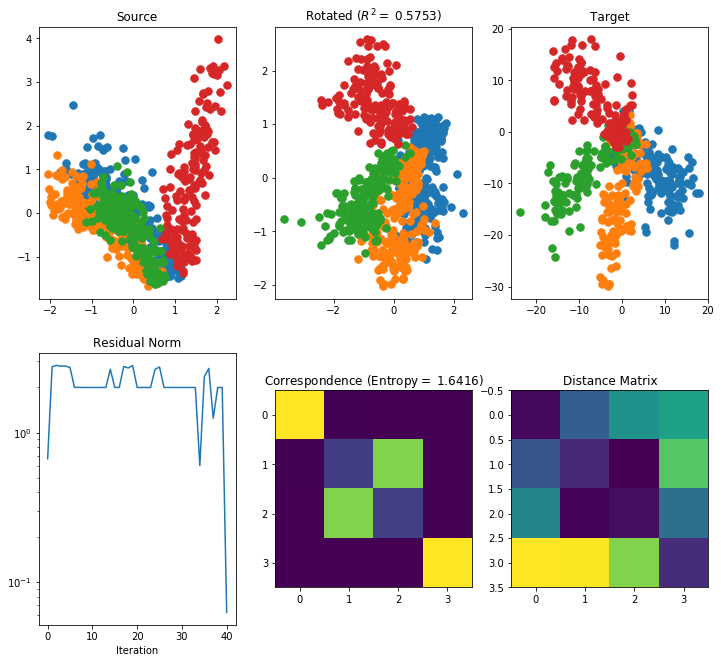

In [13]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Source')
utils.color_data(Y_te_3d, T_te)
plt.subplot(2, 3, 2)
plt.title('Rotated ($R^2 = $ %.4f)' %r2_hwa)
utils.color_data(Y_te_rec, T_te)
plt.subplot(2, 3, 3)
plt.title('Target')
utils.color_data(X_tr, T_tr)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])

### Example B - Neural recordings from rat dorsal striatum over a 24 hour period
_Data collected by_: Sam Funderburk, Keith Hengen Lab (WUSL)

#### Step 0. Load data

In [14]:
# Load the datasets from a numpy archive
with np.load('data\\sleep_day1_60s.npz') as day1z:
    ft1 = day1z['firing_times_d1']
    l1 = day1z['labels_d1']
with np.load('data\\sleep_day2_60s.npz') as day2z:
    ft2 = day2z['firing_times_d2']
    l2 = day2z['labels_d2']

#### Step 1. Dimensionality reduction

In [15]:
# Apply initial dimensionality reduction
pca = PCA(n_components=3)
ft1_3d = pca.fit_transform(ft1)
ft2_3d = pca.fit_transform(ft2)

#### Step 2. Align datasets with HiWA

In [16]:
# Fit the model and transform the source dataset
t1 = time.time()
hwa = hiwa.HiWA(dim_red_method=PCA(n_components=2), normalize=True)
ft1_rec = hwa.fit_transform(ft1_3d, l1, ft2_3d, l2)
t2 = time.time()

print('Time elapsed: {:.4f} seconds'.format(t2 - t1))

nbrs = NearestNeighbors()
nbrs.fit(ft1_rec)
idx = nbrs.kneighbors(ft2_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (l1[idx] == l2).sum() / l2.shape[0]
print('NN Accuracy: {:.2%}'.format(nn_hwa))

Time elapsed: 55.1203 seconds
NN Accuracy: 83.33%


#### Step 3. Visualize results

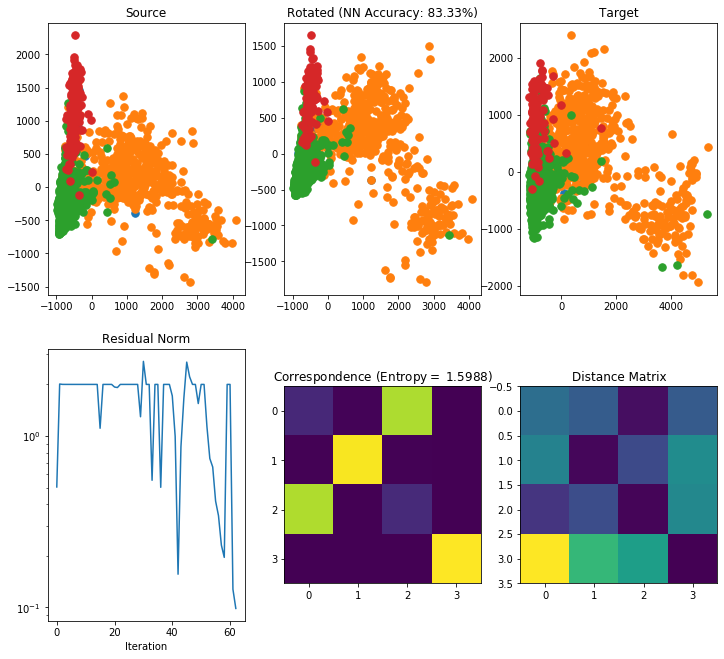

In [26]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Source')
utils.color_data(ft1_3d, l1)
plt.subplot(2, 3, 2)
plt.title('Rotated (NN Accuracy: {:.2%})'.format(nn_hwa))
utils.color_data(ft1_rec, l1)
plt.subplot(2, 3, 3)
plt.title('Target')
utils.color_data(ft2_3d, l2)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])

#### Step 4. Cluster via Gaussian Mixture Model

In [27]:
gmm = GaussianMixture(n_components=4)
l1_gmm = gmm.fit_predict(ft1_3d)
l2_gmm = gmm.fit_predict(ft2_3d)

#### Step 5. Align clustered datasets with HiWA

In [28]:
# Fit the model and transform the source dataset
t1 = time.time()
hwa = hiwa.HiWA(dim_red_method=PCA(n_components=2), normalize=True)
ft1_rec = hwa.fit_transform(ft1_3d, l1_gmm, ft2_3d, l2_gmm)
t2 = time.time()

print('Time elapsed: {:.4f} seconds'.format(t2 - t1))

nbrs = NearestNeighbors()
nbrs.fit(ft1_rec)
idx = nbrs.kneighbors(ft2_3d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (l1[idx] == l2).sum() / l2.shape[0]
print('NN Accuracy: {:.2%}'.format(nn_hwa))

Time elapsed: 10.4192 seconds
NN Accuracy: 84.44%


#### Step 6. Visualize results

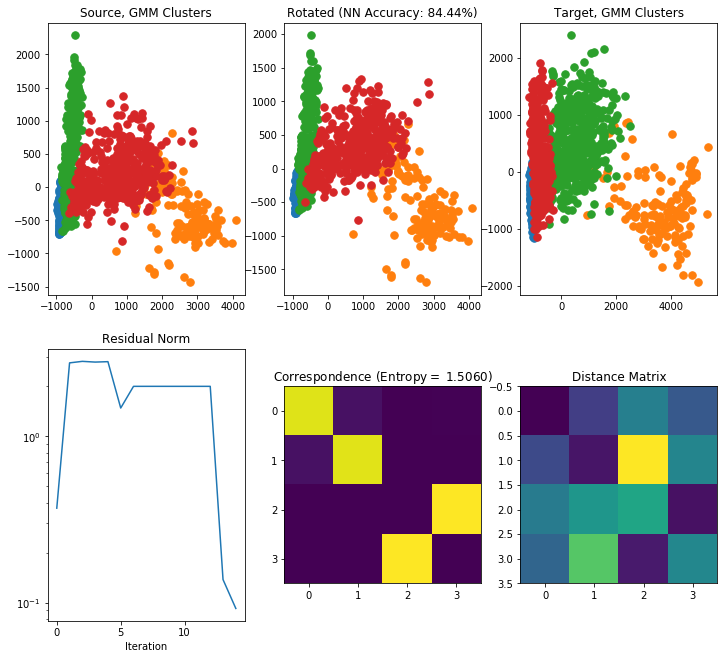

In [30]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Source, GMM Clusters')
utils.color_data(ft1_3d, l1_gmm)
plt.subplot(2, 3, 2)
plt.title('Rotated (NN Accuracy: {:.2%})'.format(nn_hwa))
utils.color_data(ft1_rec, l1_gmm)
plt.subplot(2, 3, 3)
plt.title('Target, GMM Clusters')
utils.color_data(ft2_3d, l2_gmm)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])

#### Step 7. Try to first embed data in 5D and then solve matching in 2D

In [31]:
# We're not limited to matching in 3D
pca = PCA(n_components=5)
ft1_5d = pca.fit_transform(ft1)
ft2_5d = pca.fit_transform(ft2)

# Fit the model and transform the source dataset
t1 = time.time()
hwa = hiwa.HiWA(dim_red_method=PCA(n_components=2), normalize=True)
ft2_rec = hwa.fit_transform(ft2_5d, l2, ft1_5d, l1)
t2 = time.time()

print('Time elapsed: {:.4f} seconds'.format(t2 - t1))

nbrs = NearestNeighbors()
nbrs.fit(ft2_rec)
idx = nbrs.kneighbors(ft1_5d, n_neighbors=1, return_distance=False).squeeze()
nn_hwa = (l2[idx] == l1).sum() / l1.shape[0]
print('NN Accuracy: {:.2%}'.format(nn_hwa))

Time elapsed: 9.5762 seconds
NN Accuracy: 61.11%


#### Step 8. Visualize results 

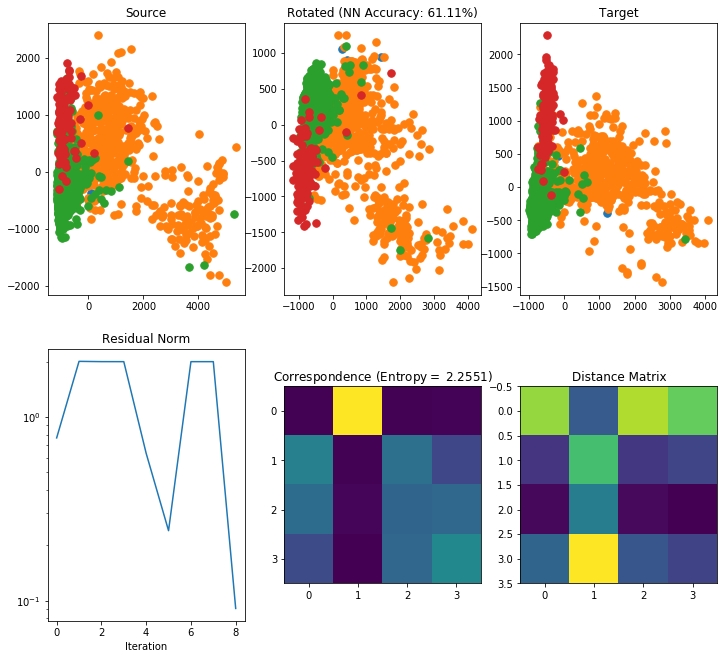

In [32]:
# Plot the results, plus some diagnostics
plt.figure(figsize=(12, 11))
plt.subplot(2, 3, 1)
plt.title('Source')
utils.color_data(ft2_5d[:,0:2], l2)
plt.subplot(2, 3, 2)
plt.title('Rotated (NN Accuracy: {:.2%})'.format(nn_hwa))
utils.color_data(ft2_rec[:,0:2], l2)
plt.subplot(2, 3, 3)
plt.title('Target')
utils.color_data(ft1_5d[:,0:2], l1)
ax = plt.subplot(2, 3, 4)
plt.plot(hwa.diagnostics['Rg_norm'])
ax.set_yscale('log')
plt.title('Residual Norm')
plt.xlabel('Iteration')
plt.subplot(2, 3, 5)
plt.imshow(hwa.P)
plt.xticks(np.arange(4))
plt.yticks(np.arange(4))
plt.title('Correspondence (Entropy$ = $ %.4f)' %(-np.sum(hwa.P * np.log(hwa.P))))
plt.subplot(2, 3, 6)
plt.title('Distance Matrix')
c = plt.imshow(hwa.diagnostics['C'])